In [1]:
import math

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [2]:
raw_words = open('first_names.all.txt').read().splitlines()
raw_words[:8]

["a'isha",
 "a'ishah",
 'a-jay',
 "aa'isha",
 "aa'ishah",
 'aaban',
 'aabas',
 'aabha']

In [3]:
block_size = 3

In [4]:
words = []
for word in raw_words:
    if word.isalpha():
        words.append(word)


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

chars_n = len(chars) + 1

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'ß', 28: 'à', 29: 'á', 30: 'â', 31: 'ã', 32: 'ä', 33: 'å', 34: 'æ', 35: 'ç', 36: 'è', 37: 'é', 38: 'ê', 39: 'ë', 40: 'ì', 41: 'í', 42: 'î', 43: 'ï', 44: 'ð', 45: 'ñ', 46: 'ò', 47: 'ó', 48: 'ô', 49: 'õ', 50: 'ö', 51: 'ø', 52: 'ù', 53: 'ú', 54: 'û', 55: 'ü', 56: 'ý', 57: 'þ', 58: 'ā', 59: 'ă', 60: 'ą', 61: 'ć', 62: 'č', 63: 'ď', 64: 'đ', 65: 'ē', 66: 'ė', 67: 'ę', 68: 'ě', 69: 'ğ', 70: 'ģ', 71: 'ī', 72: 'ı', 73: 'ĳ', 74: 'ķ', 75: 'ļ', 76: 'ľ', 77: 'ł', 78: 'ņ', 79: 'ň', 80: 'ő', 81: 'ř', 82: 'ş', 83: 'ţ', 84: 'ť', 85: 'ū', 86: 'ż', 87: 'ž', 0: '.'}


In [6]:
def build_dataset(words):
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device='cuda')
  Y = torch.tensor(Y, device='cuda')

  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [7]:
Xtr.shape, Ytr.shape

(torch.Size([963948, 3]), torch.Size([963948]))

In [45]:
emb_nd = 15

device = torch.device('cuda')

C = torch.randn((chars_n, emb_nd), device=device)
W1 = torch.randn((emb_nd * block_size, 400), device=device)
b1 = torch.randn(400, device=device)
W2 = torch.randn((400, 400), device=device)
b2 = torch.randn(400, device=device)
W3 = torch.randn((400, chars_n), device=device)
b3 = torch.randn(chars_n, device=device)
parameters = [C, W1, b1, W2, b2, W3, b3]

In [46]:
sum(p.nelement() for p in parameters)

215408

In [47]:
for p in parameters:
  p.requires_grad = True

In [52]:
step_history = []
loss_history = []
dev_loss_history = []
step = 0

In [53]:
def print_step(step: int) -> None:
    if step % 10_000 == 0:
        print(f"Step {step}: train loss {loss.log10():.4f}, dev loss {dev_loss.log10():.4f}")

In [84]:
for _ in range(20000):
  step += 1
  print_step(step)

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  x = Xtr[ix]
  emb = C[x]
  h = torch.tanh(emb.view(-1, emb_nd * block_size) @ W1 + b1)
  h = h @ W2 + b2
  logits = h @ W3 + b3
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if step < 100000 else 0.005
  for p in parameters:
    p.data += -lr * p.grad

  # dev loss
  if step % 100 == 0 or step == 1:
    with torch.no_grad():
      emb = C[Xdev]
      h = torch.tanh(emb.view(-1, emb_nd * block_size) @ W1 + b1)
      h = h @ W2 + b2
      logits = h @ W3 + b3
      dev_loss = F.cross_entropy(logits, Ydev)

  # track stats
  step_history.append(step)
  loss_history.append(loss.log10().item())
  dev_loss_history.append(dev_loss.log10().item())

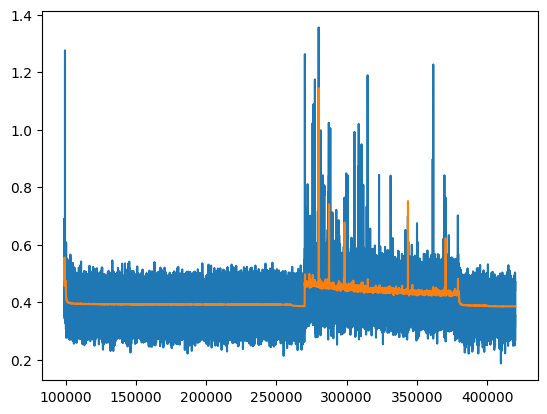

In [85]:
plt.plot(step_history[99000:], loss_history[99000:], label='train')
plt.plot(step_history[99000:], dev_loss_history[99000:], label='dev')

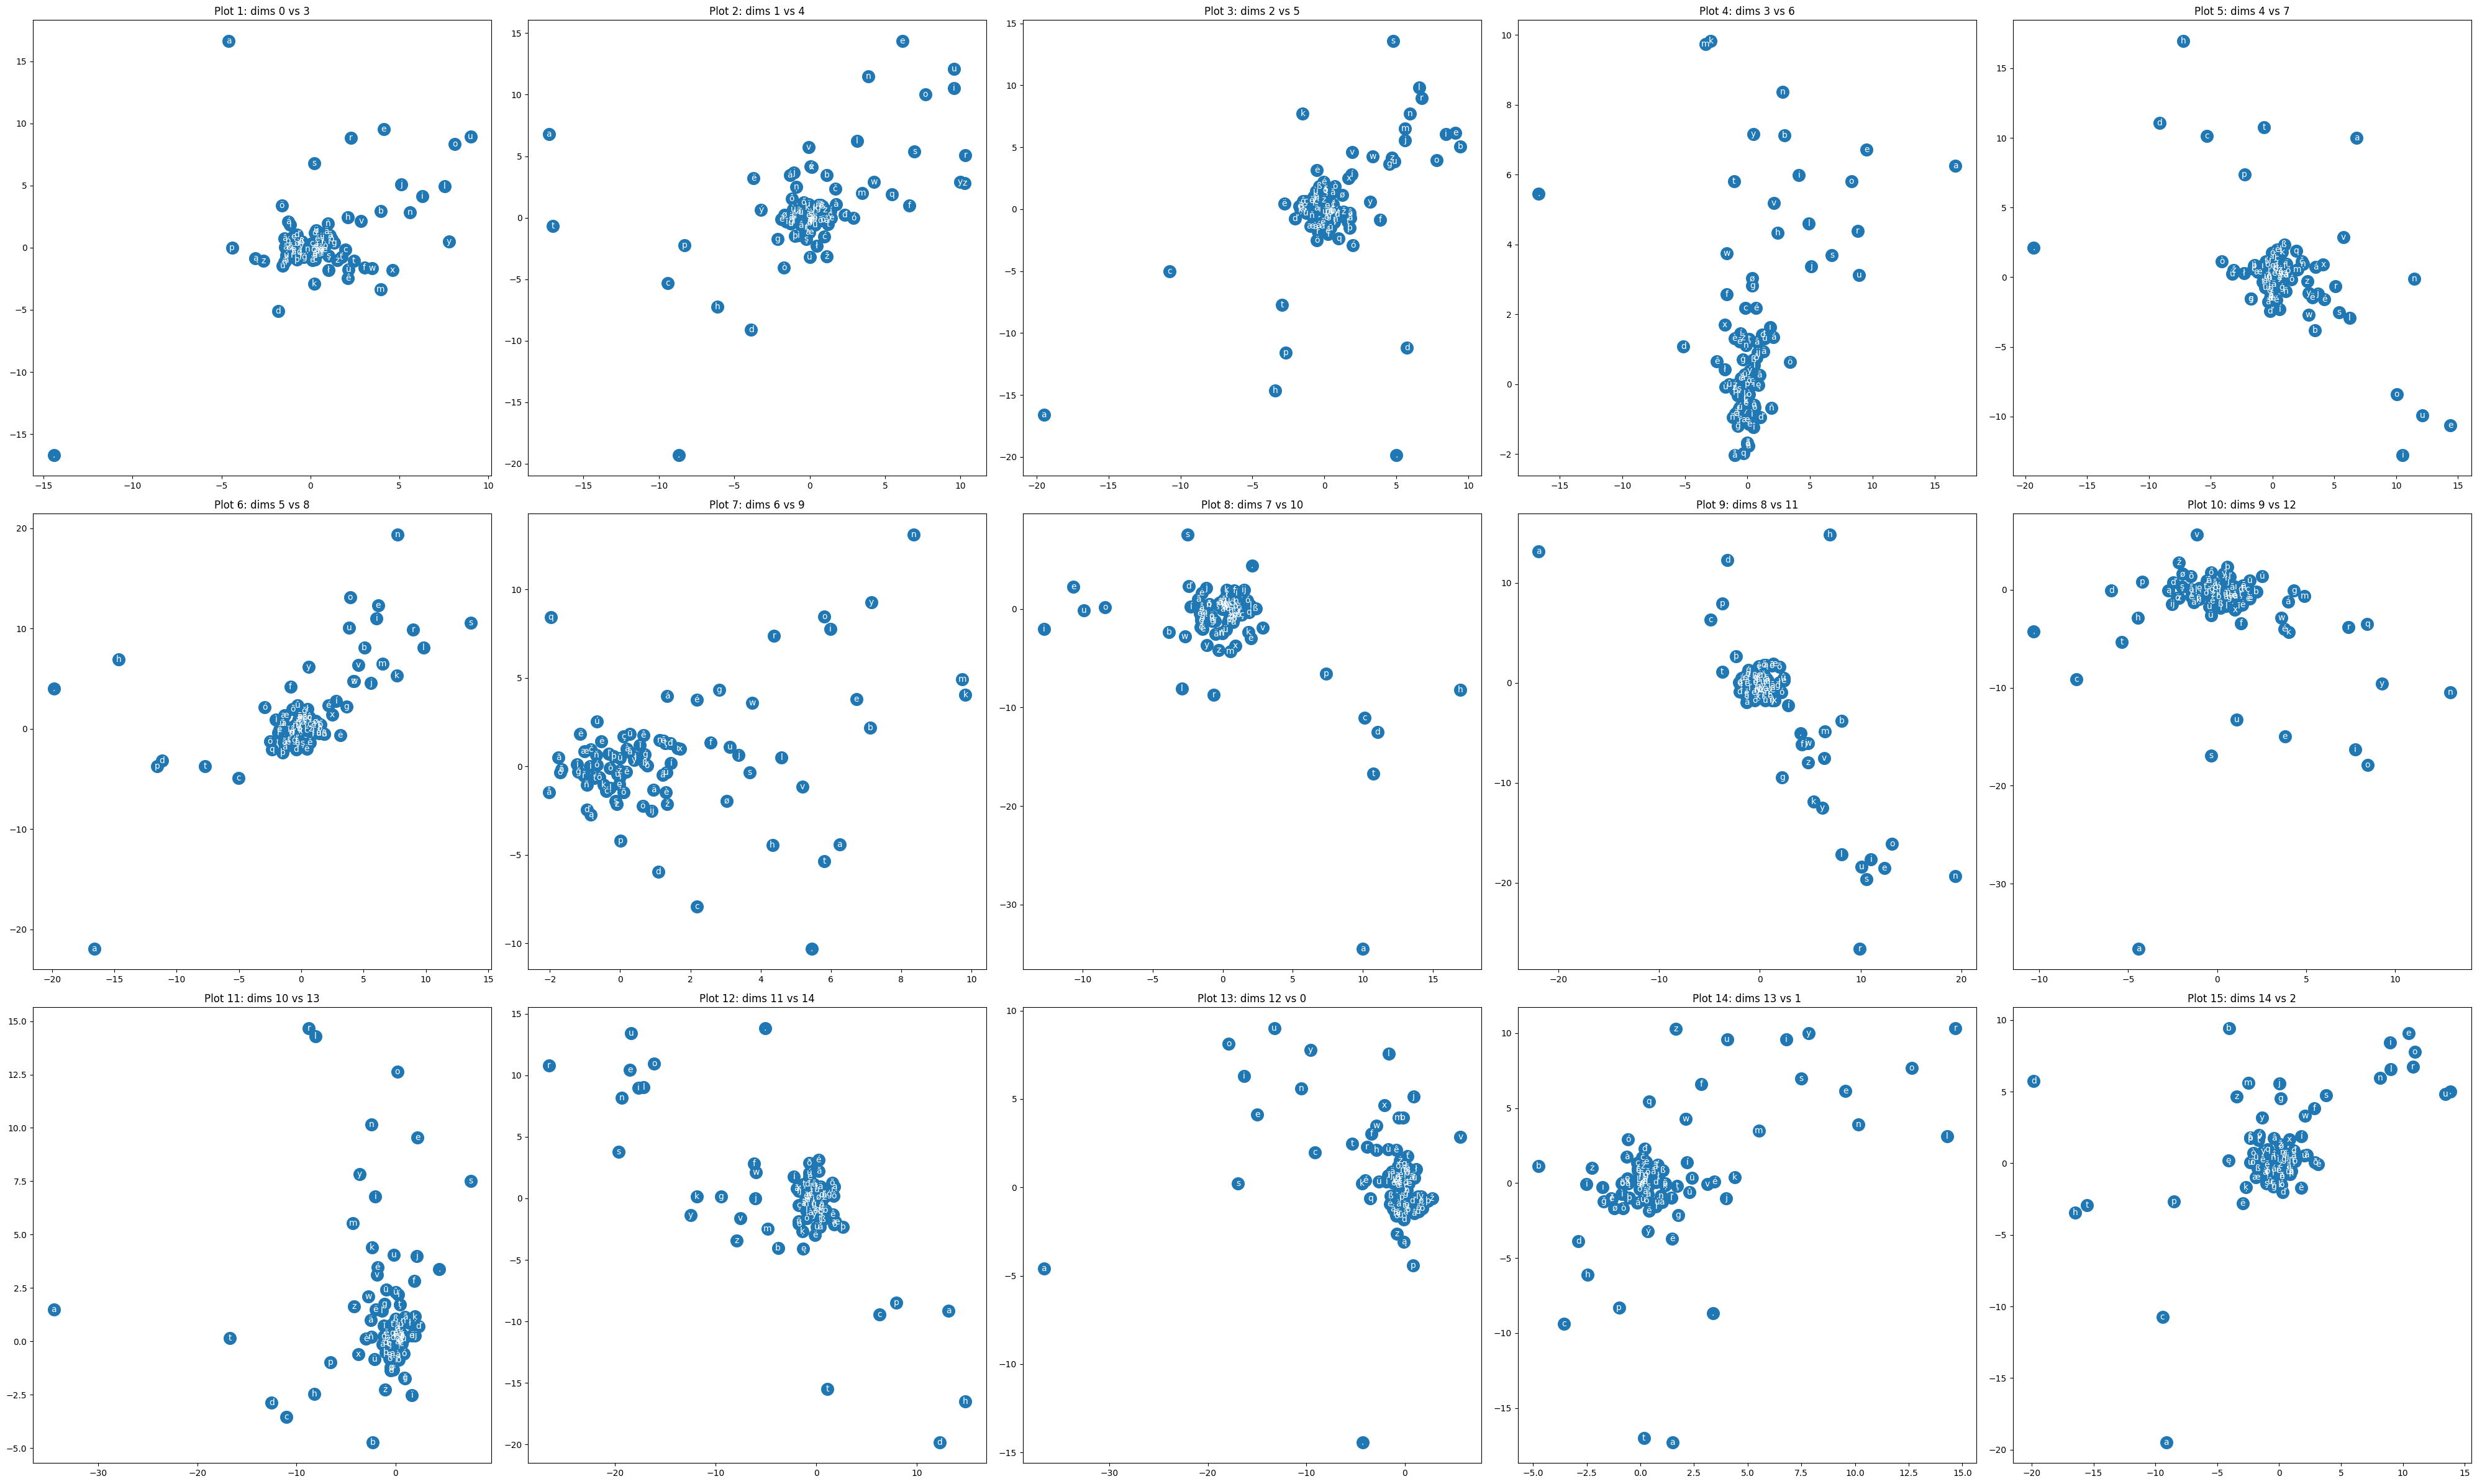

In [86]:
pairs = list(zip(list(range(emb_nd)), list((x + 3) % emb_nd for x in range(emb_nd))))
num_plots = len(pairs)
cols = 5
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))
axes = axes.flatten() if num_plots > 1 else [axes]

for idx, ((a, b), ax) in enumerate(zip(pairs, axes)):
    ax.scatter(C[:, a].data.cpu(), C[:, b].data.cpu(), s=200)
    for i in range(C.shape[0]):
        ax.text(C[i, a].item(), C[i, b].item(), itos[i], ha="center", va="center", color='white')
    ax.grid(True, which='minor')
    ax.set_title(f"Plot {idx + 1}: dims {a} vs {b}")

# Hide any unused subplots
for ax in axes[num_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [88]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context], device=device)]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      h = h @ W2 + b2
      logits = h @ W3 + b3
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

ziliy.
aya.
yohengon.
lasri.
marnn.
rena.
doriafa.
jyangh.
ally.
treni.
deneazichifan.
alreeka.
terianzr.
casminncan.
delreeam.
tamariy.
raz.
pia.
darsey.
cout.
